**Chapter 10 – Introduction to Artificial Neural Networks**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Perceptrons
irisのデータセットを用いて訓練する

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int) #セトナ？

per_clf = Perceptron(max_iter=100, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [3]:
y_pred

array([1])

Saving figure perceptron_iris_plot


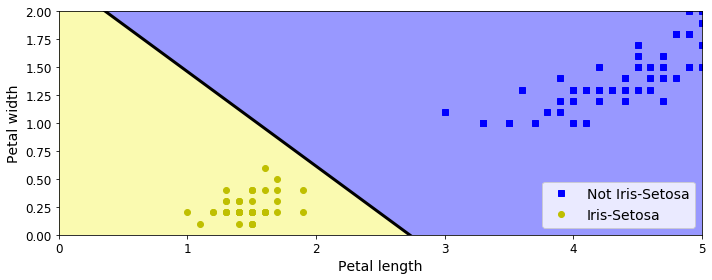

In [4]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

# Activation functions
活性化関数の紹介

In [5]:
def logit(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    # 導関数
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


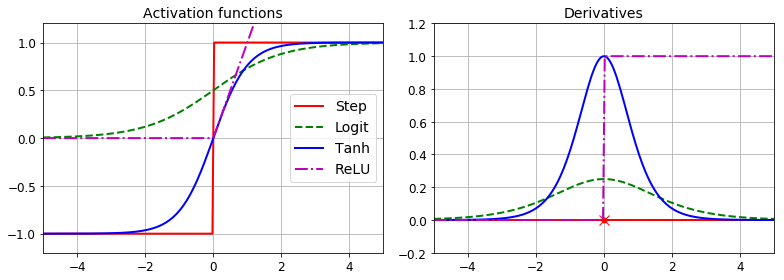

In [6]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=2, label="Step")
plt.plot(z, logit(z), "g--", linewidth=2, label="Logit")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(logit, z), "g--", linewidth=2, label="Logit")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

In [8]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def sigmoid(z):
    return 1/(1+np.exp(-z))

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)
#ヘヴィサイドとシグモイドの違いを描画

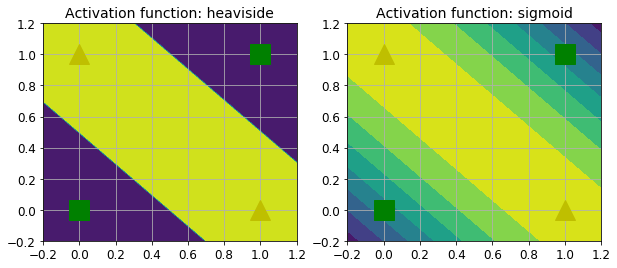

In [9]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# FNN for MNIST

## Using the Estimator API (formerly `tf.contrib.learn`)

In [10]:
import tensorflow as tf

/Users/masaki/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


**Warning**: `tf.examples.tutorials.mnist` is deprecated. We will use `tf.keras.datasets.mnist` instead. Moreover, the `tf.contrib.learn` API was promoted to `tf.estimators` and `tf.feature_columns`, and it has changed considerably. In particular, there is no `infer_real_valued_columns_from_input()` function or `SKCompat` class.

In [11]:
# MNISTのデータの準備
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0 #画素配列を一行に
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

11493376/11490434 [==============================] - 6s 1us/step


In [15]:
# feature_cols = [_NumericColumn(key='X', shape=(784,), default_value=None, dtype=tf.float32, normalizer_fn=None)]
feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
# DNNClassifierを定義、2つの隠れ層(ひとつが300のニューロン、もう一つが100のニューロン)
dnn_clf = tf.estimator.DNNClassifier(hidden_units=[300,100], n_classes=10,
                                     feature_columns=feature_cols)

# エポック40, バッチサイズ50で訓練
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, num_epochs=40, batch_size=50, shuffle=True)
dnn_clf.train(input_fn=input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/gf/dqpdrszs5_ndtggqphn3d6vh0000gn/T/tmpk2d9mfzw', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a25fa1630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/gf

INFO:tensorflow:global_step/sec: 246.922
INFO:tensorflow:loss = 0.36526123, step = 7201 (0.404 sec)
INFO:tensorflow:global_step/sec: 278.139
INFO:tensorflow:loss = 0.41671148, step = 7301 (0.359 sec)
INFO:tensorflow:global_step/sec: 255.426
INFO:tensorflow:loss = 2.745446, step = 7401 (0.392 sec)
INFO:tensorflow:global_step/sec: 252.689
INFO:tensorflow:loss = 0.56126463, step = 7501 (0.396 sec)
INFO:tensorflow:global_step/sec: 248.962
INFO:tensorflow:loss = 0.8467786, step = 7601 (0.402 sec)
INFO:tensorflow:global_step/sec: 262.297
INFO:tensorflow:loss = 0.06763508, step = 7701 (0.380 sec)
INFO:tensorflow:global_step/sec: 224.919
INFO:tensorflow:loss = 2.2828207, step = 7801 (0.446 sec)
INFO:tensorflow:global_step/sec: 249.031
INFO:tensorflow:loss = 0.12655443, step = 7901 (0.401 sec)
INFO:tensorflow:global_step/sec: 289.675
INFO:tensorflow:loss = 0.6734279, step = 8001 (0.345 sec)
INFO:tensorflow:global_step/sec: 293.387
INFO:tensorflow:loss = 0.25186267, step = 8101 (0.341 sec)
INFO:

INFO:tensorflow:global_step/sec: 292.081
INFO:tensorflow:loss = 0.10351487, step = 15401 (0.343 sec)
INFO:tensorflow:global_step/sec: 272.585
INFO:tensorflow:loss = 0.06271534, step = 15501 (0.367 sec)
INFO:tensorflow:global_step/sec: 299.723
INFO:tensorflow:loss = 0.07074359, step = 15601 (0.334 sec)
INFO:tensorflow:global_step/sec: 263.037
INFO:tensorflow:loss = 0.07926789, step = 15701 (0.380 sec)
INFO:tensorflow:global_step/sec: 262.28
INFO:tensorflow:loss = 0.14250237, step = 15801 (0.381 sec)
INFO:tensorflow:global_step/sec: 290.975
INFO:tensorflow:loss = 0.06762756, step = 15901 (0.344 sec)
INFO:tensorflow:global_step/sec: 295.769
INFO:tensorflow:loss = 0.15572195, step = 16001 (0.338 sec)
INFO:tensorflow:global_step/sec: 292.661
INFO:tensorflow:loss = 0.053051107, step = 16101 (0.341 sec)
INFO:tensorflow:global_step/sec: 291.5
INFO:tensorflow:loss = 0.23066226, step = 16201 (0.343 sec)
INFO:tensorflow:global_step/sec: 292.776
INFO:tensorflow:loss = 0.13700265, step = 16301 (0.3

INFO:tensorflow:global_step/sec: 290.79
INFO:tensorflow:loss = 0.036087133, step = 23501 (0.344 sec)
INFO:tensorflow:global_step/sec: 299.684
INFO:tensorflow:loss = 0.025718454, step = 23601 (0.334 sec)
INFO:tensorflow:global_step/sec: 290.711
INFO:tensorflow:loss = 0.01858178, step = 23701 (0.344 sec)
INFO:tensorflow:global_step/sec: 292.971
INFO:tensorflow:loss = 0.031270135, step = 23801 (0.341 sec)
INFO:tensorflow:global_step/sec: 268.591
INFO:tensorflow:loss = 0.045847222, step = 23901 (0.372 sec)
INFO:tensorflow:global_step/sec: 291.318
INFO:tensorflow:loss = 0.04910595, step = 24001 (0.343 sec)
INFO:tensorflow:global_step/sec: 292.142
INFO:tensorflow:loss = 0.03713611, step = 24101 (0.342 sec)
INFO:tensorflow:global_step/sec: 287.897
INFO:tensorflow:loss = 0.038501944, step = 24201 (0.347 sec)
INFO:tensorflow:global_step/sec: 289.02
INFO:tensorflow:loss = 0.016264096, step = 24301 (0.346 sec)
INFO:tensorflow:global_step/sec: 292.745
INFO:tensorflow:loss = 0.029104598, step = 244

INFO:tensorflow:global_step/sec: 272.969
INFO:tensorflow:loss = 0.024587069, step = 31601 (0.366 sec)
INFO:tensorflow:global_step/sec: 301.205
INFO:tensorflow:loss = 0.008764269, step = 31701 (0.332 sec)
INFO:tensorflow:global_step/sec: 289.984
INFO:tensorflow:loss = 0.0058928723, step = 31801 (0.345 sec)
INFO:tensorflow:global_step/sec: 288.905
INFO:tensorflow:loss = 0.011610931, step = 31901 (0.346 sec)
INFO:tensorflow:global_step/sec: 290.626
INFO:tensorflow:loss = 0.01782419, step = 32001 (0.344 sec)
INFO:tensorflow:global_step/sec: 294.551
INFO:tensorflow:loss = 0.017698918, step = 32101 (0.340 sec)
INFO:tensorflow:global_step/sec: 273.327
INFO:tensorflow:loss = 0.0030015414, step = 32201 (0.366 sec)
INFO:tensorflow:global_step/sec: 295.643
INFO:tensorflow:loss = 0.010776365, step = 32301 (0.338 sec)
INFO:tensorflow:global_step/sec: 290.535
INFO:tensorflow:loss = 0.012677452, step = 32401 (0.344 sec)
INFO:tensorflow:global_step/sec: 266.964
INFO:tensorflow:loss = 0.023290232, step

INFO:tensorflow:loss = 0.008984459, step = 39601 (0.423 sec)
INFO:tensorflow:global_step/sec: 242.181
INFO:tensorflow:loss = 0.020639969, step = 39701 (0.413 sec)
INFO:tensorflow:global_step/sec: 250.411
INFO:tensorflow:loss = 0.008348488, step = 39801 (0.399 sec)
INFO:tensorflow:global_step/sec: 283.223
INFO:tensorflow:loss = 0.024097148, step = 39901 (0.353 sec)
INFO:tensorflow:global_step/sec: 288.101
INFO:tensorflow:loss = 0.0005584195, step = 40001 (0.347 sec)
INFO:tensorflow:global_step/sec: 279.009
INFO:tensorflow:loss = 0.0021684011, step = 40101 (0.358 sec)
INFO:tensorflow:global_step/sec: 257.999
INFO:tensorflow:loss = 0.02104681, step = 40201 (0.389 sec)
INFO:tensorflow:global_step/sec: 289.389
INFO:tensorflow:loss = 0.0064181965, step = 40301 (0.344 sec)
INFO:tensorflow:global_step/sec: 275.069
INFO:tensorflow:loss = 0.018387135, step = 40401 (0.363 sec)
INFO:tensorflow:global_step/sec: 267.258
INFO:tensorflow:loss = 0.0022321758, step = 40501 (0.374 sec)
INFO:tensorflow:gl

In [20]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_test}, y=y_test, shuffle=False)
eval_results = dnn_clf.evaluate(input_fn=test_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-11-02:19:12
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/gf/dqpdrszs5_ndtggqphn3d6vh0000gn/T/tmpk2d9mfzw/model.ckpt-44000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-11-02:19:13
INFO:tensorflow:Saving dict for global step 44000: accuracy = 0.9814, average_loss = 0.102583215, global_step = 44000, loss = 12.985217


In [21]:
eval_results

{'accuracy': 0.9814,
 'average_loss': 0.102583215,
 'global_step': 44000,
 'loss': 12.985217}

In [22]:
y_pred_iter = dnn_clf.predict(input_fn=test_input_fn)
y_pred = list(y_pred_iter)
y_pred[0]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/gf/dqpdrszs5_ndtggqphn3d6vh0000gn/T/tmpk2d9mfzw/model.ckpt-44000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'class_ids': array([7]),
 'classes': array([b'7'], dtype=object),
 'logits': array([ -5.5720415 ,  -7.036467  ,   0.36587664,   4.6229787 ,
        -14.318101  , -14.143025  , -20.92571   ,  21.329973  ,
         -3.896146  ,  -5.7098355 ], dtype=float32),
 'probabilities': array([2.0730178e-12, 4.7930475e-13, 7.8597506e-10, 5.5493775e-08,
        3.2979016e-16, 3.9289094e-16, 4.4523534e-19, 1.0000000e+00,
        1.1077335e-11, 1.8061777e-12], dtype=float32)}

## Using plain TensorFlow
10.3 プレーンなtfを使ってDNNの訓練

In [23]:
import tensorflow as tf

n_inputs = 28*28  # MNISTのサイズ
n_hidden1 = 300 #隠れ層のニューロンの数
n_hidden2 = 100
n_outputs = 10 #クラス数(出力のニューロン数)

In [24]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X") #何行(インスタンス数)になるかはわからないのでNone
y = tf.placeholder(tf.int32, shape=(None), name="y") #これもインスタンス数がわからないのでNone

In [25]:
# 層を定義する関数をつくる。
# 最後の層はsoftmaxで出力したいので活性化関数も定義できるように
def neuron_layer(X, n_neurons, name, activation=None):
    # 名前スコープの定義(スッキリする)
    with tf.name_scope(name):
        # inputの次元数
        n_inputs = int(X.get_shape()[1])
        
        # 重み行列Wを作っている。Wは個々の入力と個々のニューロンのエッヂの重みを格納する行列である。
        # 標準偏差がstddevの切断正規分布の乱数だと収束が早い
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        
        # バイアスは0で初期化
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        # X行列とW行列を掛け合わせる→行列ができる。
        #+bは次元数が合わないように思われるがその通り
        # bという一次元配列は行列の各行に加えられる。
        Z = tf.matmul(X, W) + b
        # 活性化関数
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [26]:
with tf.name_scope("dnn"):
    # Xを受け取りhidden1を出力
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu) #活性化関数はレル
    # hidden1を受け取りhidden2を出力
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    # hidden2を受け取りソフトマックスに通す前の値を出力
    logits = neuron_layer(hidden2, n_outputs, name="outputs")

In [27]:
with tf.name_scope("loss"):
    # 損失関数の定義。ソフトマックスの前の出力はlogitとよぶ。
    # それの交差エントロピーを計算する関数。
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    # 交差エントロピーの平均
    loss = tf.reduce_mean(xentropy, name="loss")

In [28]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    # 損失が最小になるように
    training_op = optimizer.minimize(loss)

In [29]:
with tf.name_scope("eval"):
    # in_top_k...最高のlogitがターゲット(y)に対応するか調べる関数
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [30]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [31]:
# エポック数とバッチ数を定義
n_epochs = 40
batch_size = 50

In [32]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        # yieldは、関数を一時的に実行停止させることが出来る機能を持つ文です。
        # その時点での戻り値を返し、そしてまた再開させることができます。

In [33]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, "Val accuracy:", acc_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.9 Val accuracy: 0.9146
1 Batch accuracy: 0.92 Val accuracy: 0.936
2 Batch accuracy: 0.96 Val accuracy: 0.945
3 Batch accuracy: 0.92 Val accuracy: 0.9508
4 Batch accuracy: 0.98 Val accuracy: 0.956
5 Batch accuracy: 0.96 Val accuracy: 0.9566
6 Batch accuracy: 1.0 Val accuracy: 0.9614
7 Batch accuracy: 0.96 Val accuracy: 0.9632
8 Batch accuracy: 0.98 Val accuracy: 0.9652
9 Batch accuracy: 0.96 Val accuracy: 0.9658
10 Batch accuracy: 0.92 Val accuracy: 0.9688
11 Batch accuracy: 0.98 Val accuracy: 0.9684
12 Batch accuracy: 0.98 Val accuracy: 0.9676
13 Batch accuracy: 0.98 Val accuracy: 0.9712
14 Batch accuracy: 1.0 Val accuracy: 0.9714
15 Batch accuracy: 0.94 Val accuracy: 0.9732
16 Batch accuracy: 1.0 Val accuracy: 0.9736
17 Batch accuracy: 1.0 Val accuracy: 0.9742
18 Batch accuracy: 1.0 Val accuracy: 0.9746
19 Batch accuracy: 0.98 Val accuracy: 0.9746
20 Batch accuracy: 1.0 Val accuracy: 0.976
21 Batch accuracy: 1.0 Val accuracy: 0.9756
22 Batch accuracy: 0.98 Val accu

In [34]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
    X_new_scaled = X_test[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


In [35]:
print("Predicted classes:", y_pred)
print("Actual classes:   ", y_test[:20])

Predicted classes: [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]
Actual classes:    [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


In [36]:
from tensorflow_graph_in_jupyter import show_graph

In [37]:
show_graph(tf.get_default_graph())

## Using `dense()` instead of `neuron_layer()`
前は自分で定義した関数を使ってレイヤーを制作していたが、もちろんtfはそういうレイヤーを作る関数も用意している。

Note: previous releases of the book used `tensorflow.contrib.layers.fully_connected()` rather than `tf.layers.dense()` (which did not exist when this chapter was written). **It is now preferable to use `tf.layers.dense()`**, because anything in the contrib module may change or be deleted without notice. The `dense()` function is almost identical to the `fully_connected()` function, except for a few minor differences:
* several parameters are renamed: `scope` becomes `name`, `activation_fn` becomes `activation` (and similarly the `_fn` suffix is removed from other parameters such as `normalizer_fn`), `weights_initializer` becomes `kernel_initializer`, etc.
* the default `activation` is now `None` rather than `tf.nn.relu`.
* a few more differences are presented in chapter 11.

In [38]:
n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [39]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y") 

In [40]:
with tf.name_scope("dnn"):
    # tf.layers.denseを使って全結合層を簡単に定義できる
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    y_proba = tf.nn.softmax(logits)

In [41]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [42]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [43]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [44]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [45]:
n_epochs = 20
n_batches = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.9 Validation accuracy: 0.9024
1 Batch accuracy: 0.92 Validation accuracy: 0.9254
2 Batch accuracy: 0.94 Validation accuracy: 0.9372
3 Batch accuracy: 0.9 Validation accuracy: 0.9416
4 Batch accuracy: 0.94 Validation accuracy: 0.9472
5 Batch accuracy: 0.94 Validation accuracy: 0.9512
6 Batch accuracy: 1.0 Validation accuracy: 0.9548
7 Batch accuracy: 0.94 Validation accuracy: 0.961
8 Batch accuracy: 0.96 Validation accuracy: 0.9622
9 Batch accuracy: 0.94 Validation accuracy: 0.9648
10 Batch accuracy: 0.92 Validation accuracy: 0.9656
11 Batch accuracy: 0.98 Validation accuracy: 0.9666
12 Batch accuracy: 0.98 Validation accuracy: 0.9684
13 Batch accuracy: 0.98 Validation accuracy: 0.9704
14 Batch accuracy: 1.0 Validation accuracy: 0.9694
15 Batch accuracy: 0.94 Validation accuracy: 0.9718
16 Batch accuracy: 0.98 Validation accuracy: 0.9726
17 Batch accuracy: 1.0 Validation accuracy: 0.9728
18 Batch accuracy: 0.98 Validation accuracy: 0.9744
19 Batch accuracy: 0.98 Vali

In [46]:
show_graph(tf.get_default_graph())

# Exercise solutions

## 1. to 8.

See appendix A.

## 9.

_Train a deep MLP on the MNIST dataset and see if you can get over 98% precision. Just like in the last exercise of chapter 9, try adding all the bells and whistles (i.e., save checkpoints, restore the last checkpoint in case of an interruption, add summaries, plot learning curves using TensorBoard, and so on)._

First let's create the deep net. It's exactly the same as earlier, with just one addition: we add a `tf.summary.scalar()` to track the loss and the accuracy during training, so we can view nice learning curves using TensorBoard.

In [ ]:
n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [ ]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y") 

In [ ]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [ ]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    loss_summary = tf.summary.scalar('log_loss', loss)

In [ ]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [ ]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    accuracy_summary = tf.summary.scalar('accuracy', accuracy)

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Now we need to define the directory to write the TensorBoard logs to:

In [ ]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [ ]:
logdir = log_dir("mnist_dnn")

Now we can create the `FileWriter` that we will use to write the TensorBoard logs:

In [ ]:
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

Hey! Why don't we implement early stopping? For this, we are going to need to use the validation set.

In [ ]:
m, n = X_train.shape

In [ ]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_deep_mnist_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_deep_mnist_model"

best_loss = np.infty
epochs_without_progress = 0
max_epochs_without_progress = 50

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val, loss_val, accuracy_summary_str, loss_summary_str = sess.run([accuracy, loss, accuracy_summary, loss_summary], feed_dict={X: X_valid, y: y_valid})
        file_writer.add_summary(accuracy_summary_str, epoch)
        file_writer.add_summary(loss_summary_str, epoch)
        if epoch % 5 == 0:
            print("Epoch:", epoch,
                  "\tValidation accuracy: {:.3f}%".format(accuracy_val * 100),
                  "\tLoss: {:.5f}".format(loss_val))
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))
            if loss_val < best_loss:
                saver.save(sess, final_model_path)
                best_loss = loss_val
            else:
                epochs_without_progress += 5
                if epochs_without_progress > max_epochs_without_progress:
                    print("Early stopping")
                    break

In [ ]:
os.remove(checkpoint_epoch_path)

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, final_model_path)
    accuracy_val = accuracy.eval(feed_dict={X: X_test, y: y_test})

In [ ]:
accuracy_val